In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *
import warnings
warnings.filterwarnings('ignore')

In [4]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/'

SoFi_keys = ['Tinatinv4_2factor_profile', 'Tinatinv4_2factor_timeseries']
Ref_keys = ['002_HOA', '011_HOA', '014_HOA', '003_OOA', '007_LO-OOA', '010_LO-OOA', '005_MO-OOA', '009_MO-OOA', '012_MO-OOA', '030_Birchen', '039_Oak', '041_Pinetree', '042_Poplar']

SoFi = read_txt(f'{path}cph central and nørreport measurements/SoFi resultater/', parent_path, SoFi_keys, '\t', None)
for key in [key for key in SoFi_keys if 'timeseries' in key]:
    SoFi[key]['Time'] = pd.to_datetime(SoFi[key]['Time'])

Ref_MS = read_txt(f'{path}ref ms/txt files/', parent_path, Ref_keys, '\t', None)

In [15]:
for key in [key for key in Ref_keys if 'HOA' in key]:
    print(Ref_MS[key].keys())

Index(['m/z', 'HOA_CS (002)', 'HOA_Cx (002)', 'HOA_CxHy (002)',
       'HOA_CxHyNp (002)', 'HOA_CxHyO (002)', 'HOA_CxHyOgt1 (002)',
       'HOA_CxHyOgt1N (002)', 'HOA_CxHyON (002)', 'HOA_HxO (002)',
       'HOA_other (002)', 'HOA_total (002)'],
      dtype='object')
Index(['Intensity (011)', 'm/z'], dtype='object')
Index(['m/z', 'HOA_CS (014)', 'HOA_Cx (014)', 'HOA_CxHy (014)',
       'HOA_CxHyNp (014)', 'HOA_CxHyO (014)', 'HOA_CxHyOgt1 (014)',
       'HOA_CxHyOgt1N (014)', 'HOA_CxHyON (014)', 'HOA_HxO (014)',
       'HOA_other (014)', 'HOA total (014)'],
      dtype='object')


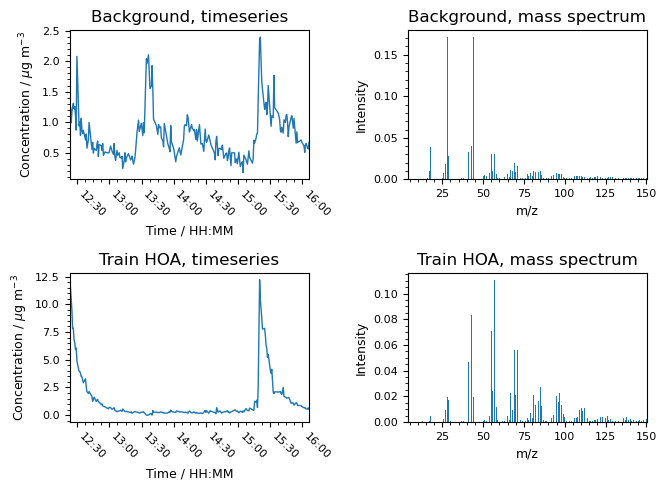

In [13]:
fig, ax = plt.subplots(2, 2, figsize = (6.7, 5))

plot_total(ax[0][0], SoFi['Tinatinv4_2factor_timeseries'], 'background', 'tab:blue', '-')
ax[0][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = 'Background, timeseries')
plot_MS(ax[0][1], SoFi['Tinatinv4_2factor_profile'], 'background', 0.5, 'Background, mass spectrum')

plot_total(ax[1][0], SoFi['Tinatinv4_2factor_timeseries'], 'train HOA', 'tab:blue', '-')
ax[1][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = 'Train HOA, timeseries')
plot_MS(ax[1][1], SoFi['Tinatinv4_2factor_profile'], 'train HOA', 0.5, 'Train HOA, mass spectrum')

fig.tight_layout()
fig.savefig('SoFi/Tinatin_PMF.png', dpi = 600)
plt.show()

In [25]:
def PMF_MS_validation(axes, PMF_df, PMF_key, Ref_dict, Ref_dict_keys, Ref_df_keys):
    for i, key in enumerate(Ref_dict_keys):
        merged = pd.merge(PMF_df, Ref_dict[key], on = 'm/z')
        PMF_total_int, Ref_total_int = pd.to_numeric(merged[PMF_key], errors = 'coerce').sum(), pd.to_numeric(merged[Ref_df_keys[i]], errors = 'coerce').sum()
        merged['PMF scaled'] = pd.to_numeric(merged[PMF_key], errors = 'coerce') / PMF_total_int
        merged['Ref scaled'] = pd.to_numeric(merged[Ref_df_keys[i]], errors = 'coerce') / Ref_total_int

        fit_params, fit_errors, Ndof_fit, squares_fit, R2 = linear_fit(merged['PMF scaled'], merged['Ref scaled'], linear, a_guess = 1, b_guess = 0)
        y_fit = linear(merged['PMF scaled'], *fit_params)

        axes[i].plot(merged['PMF scaled'], y_fit, label = 'Fit', color = 'k', lw = 1.2)
        axes[i].scatter(merged['PMF scaled'], merged['Ref scaled'], s = 10, c = 'blue', label = None)

        axes[i].legend()

        print(f'({fit_params[0]:.3f} +- {fit_errors[0]:.4f})x + ({fit_params[1]:.3f} +- {fit_errors[1]:.4f}), R2 = {R2}')

    return axes

(0.532 +- 5.4088)x + (0.003 +- 0.0903), R2 = 0.2156361972902708
(0.223 +- 5.4090)x + (0.008 +- 0.1130), R2 = 0.016613234774652104
(0.678 +- 5.4088)x + (0.002 +- 0.0903), R2 = 0.4638082096190963


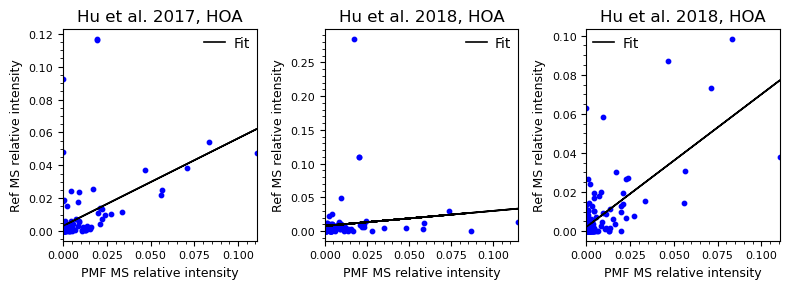

In [34]:
fig, axes = plt.subplots(1, 3, figsize = (8, 3))

Ref_df_keys = ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']

titles = ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA']

PMF_MS_validation(axes, SoFi['Tinatinv4_2factor_profile'], 'train HOA', Ref_MS, Ref_keys[:3], Ref_df_keys)

for ax, ttl in zip(axes, titles):
    ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity')

fig.tight_layout()
fig.savefig('SoFi/PMF_tinatin_trainHOAvsRef.png', dpi = 600)
plt.show()

(0.711 +- 4.0250)x + (0.002 +- 0.0869), R2 = 0.6954135811252389
(0.679 +- 3.9562)x + (0.003 +- 0.1069), R2 = 0.28653740500398284
(0.182 +- 4.0250)x + (0.006 +- 0.0869), R2 = 0.06050095706692031
(1.170 +- 4.0250)x + (-0.001 +- 0.0869), R2 = 0.8325132079643123
(1.181 +- 3.9235)x + (-0.002 +- 0.1113), R2 = 0.9262021932043114
(1.610 +- 3.9562)x + (-0.006 +- 0.1069), R2 = 0.9372001195110674


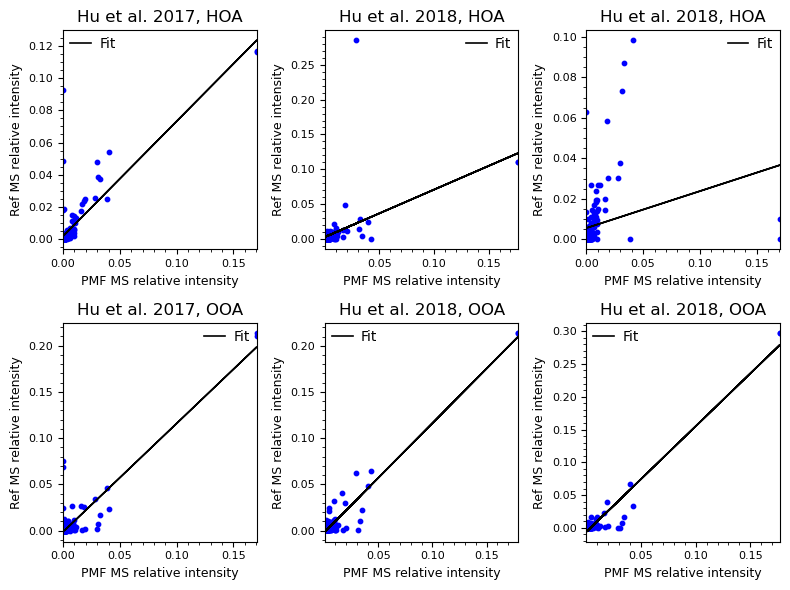

In [35]:
fig, axes = plt.subplots(2, 3, figsize = (8, 6))

Ref_df_keys_HOA = ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']
Ref_df_keys_LOOOA = ['OOA total (003)', 'Intensity (007)', 'Intensity (010)']

titles = ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2017, OOA', 'Hu et al. 2018, OOA', 'Hu et al. 2018, OOA']

PMF_MS_validation(axes[0], SoFi['Tinatinv4_2factor_profile'], 'background', Ref_MS, Ref_keys[:3], Ref_df_keys_HOA)
PMF_MS_validation(axes[1], SoFi['Tinatinv4_2factor_profile'], 'background', Ref_MS, Ref_keys[3:6], Ref_df_keys_LOOOA)

for ax, ttl in zip(axes.flatten(), titles):
    ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity')

fig.tight_layout()
fig.savefig('SoFi/PMF_tinatin_BGvsRef.png', dpi = 600)
plt.show()